In [28]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from sklearn.preprocessing import MinMaxScaler

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [29]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette('coolwarm')

In [30]:
path = Path('../data/quora')
list(path.iterdir())

[PosixPath('../data/quora/df_fe_without_preprocessing_train.csv'),
 PosixPath('../data/quora/nlp_features_train.csv'),
 PosixPath('../data/quora/quora-question-pairs.zip'),
 PosixPath('../data/quora/sample_submission.csv'),
 PosixPath('../data/quora/train.csv'),
 PosixPath('../data/quora/train_n.txt'),
 PosixPath('../data/quora/train_p.txt')]

In [5]:
df = pd.read_csv(path/"df_fe_without_preprocessing_train.csv",encoding='latin-1')
df = df.fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2> Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [25]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile("\W")
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example = BeautifulSoup(x)
        x = example.get_text()
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [7]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

In [8]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    #Computing Fuzzy Features and Merging with Dataset
    
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [10]:
df = pd.read_csv(path/"train.csv")
df = extract_features(df)
df.to_csv(path/"nlp_features_train.csv", index=False)

In [49]:
df = pd.read_csv(path/"nlp_features_train.csv",encoding='latin-1')
df.fillna('')
print(df.shape)
df.head()

(404290, 21)


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


<h3> Analysis of extracted features </h3>

<h4> Plotting Word clouds </h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [50]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like [[1,2], [3,4]] to [1,2,3,4]

p = np.dstack([df_duplicate.question1, df_duplicate.question2]).flatten()
n = np.dstack([df_nonduplicate.question1, df_nonduplicate.question2]).flatten()

print(f"Number of data points in class 1 (duplicate pairs):: {len(p)}")
print(f"Number of data points in class 0 (non-duplicate pairs):: {len(n)}")

Number of data points in class 1 (duplicate pairs):: 298526
Number of data points in class 0 (non-duplicate pairs):: 510054


In [51]:
#Saving the np array into a text file
np.savetxt(path/'train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt(path/'train_n.txt', n, delimiter=' ', fmt='%s')

In [52]:
# reading the text files and removing the Stop Words:
textp_w = open(path/'train_p.txt').read()
textn_w = open(path/'train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


#### Word clouds from duplicate question text

Word Cloud for duplicate question pairs


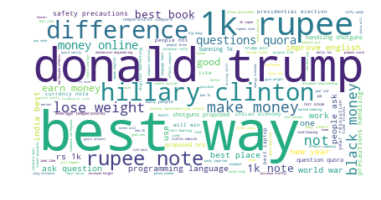

In [33]:
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word clouds from non-duplicate question text

Word Cloud for non-duplicate question pairs


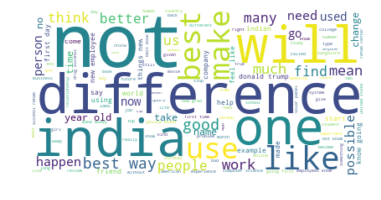

In [34]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

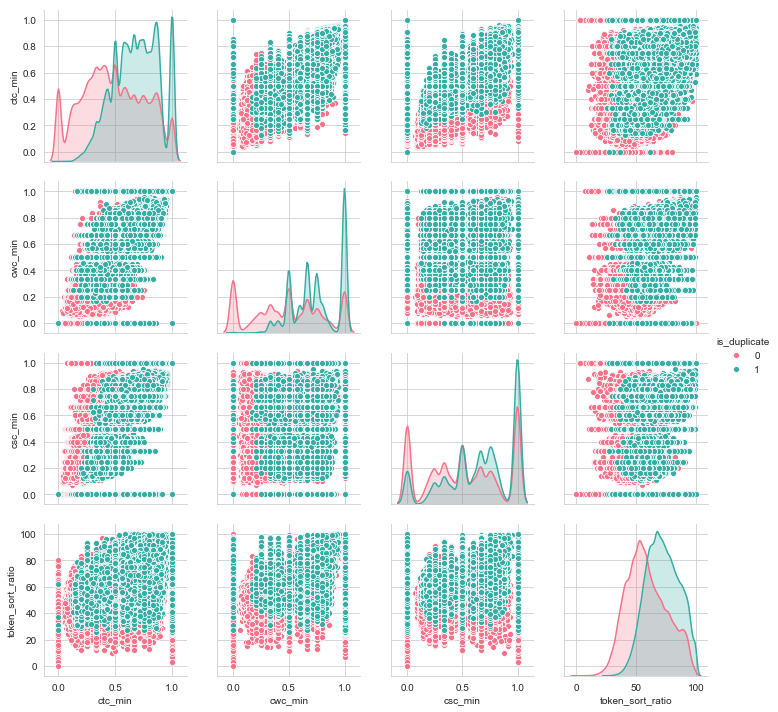

In [53]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'], palette='husl')
plt.show()

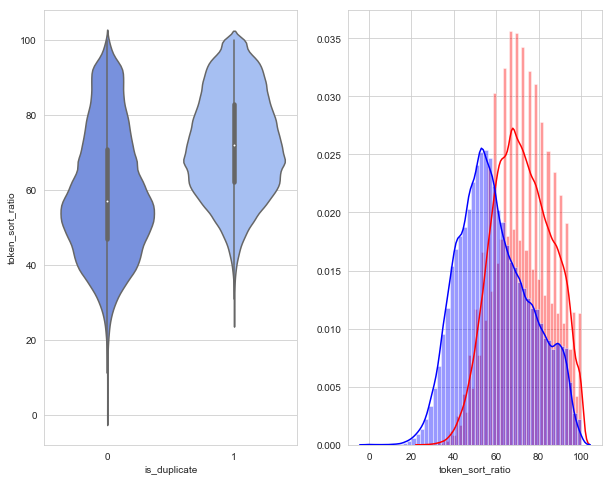

In [54]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'] , label = "0" , color = 'blue' )
plt.show()

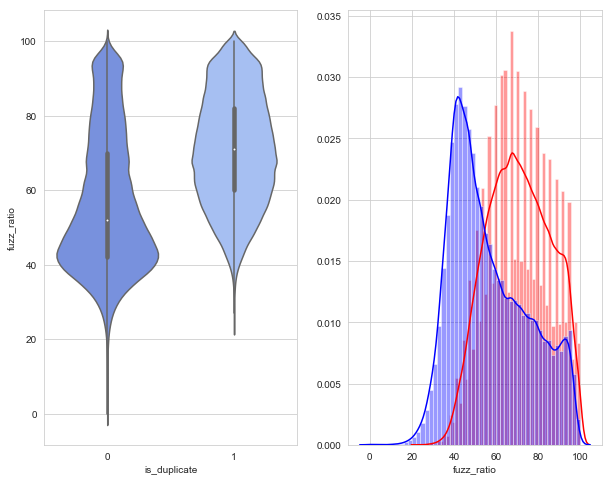

In [55]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'] , label = "0" , color = 'blue' )
plt.show()

## Visualization

In [56]:
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values


In [59]:
tsne2d = TSNE(
    n_components = 2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.012s...
[t-SNE] Computed neighbors for 5000 samples in 0.391s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.203s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.980s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 2.212s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 2.203s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 2.267s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

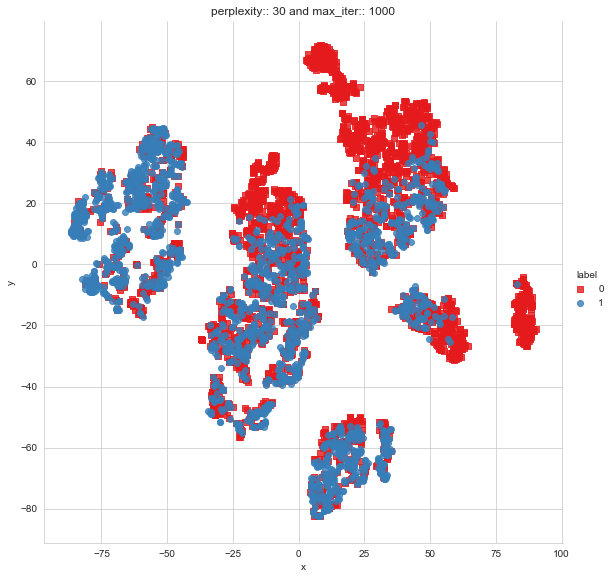

In [61]:
df = pd.DataFrame({'x': tsne2d[:, 0], 'y': tsne2d[:, 1], 'label': y})

sns.lmplot(x='x', y='y', data=df, hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title(f"perplexity:: {30} and max_iter:: {1000}")
plt.show()




In [63]:
tsne3d = TSNE(
    n_components = 3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.193s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 9.503s)
[t-SNE] Iteration 100: error = 69.1120148, gradient norm = 0.0033901 (50 iterations in 5.526s)
[t-SNE] Iteration 150: error = 67.6176224, gradient norm = 0.0017826 (50 iterations in 4.972s)
[t-SNE] Iteration 200: error = 67.0574570, gradient norm = 0.0014586 (50 iterations in 4.951s)
[t-SNE] Iteration 250: error = 66.7299194, gradient norm = 0.0009065

In [64]:
trace1 = go.Scatter3d(
    x = tsne3d[:, 0],
    y = tsne3d[:, 1],
    z = tsne3d[:, 2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorbar = dict(title = 'duplicate'),
        line = dict(color='rgb(255, 255, 255)'),
        opacity = 0.75
    )
)

data = [trace1]
layout = dict(height=800, width=800, title='3d embedding with engineered features')
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')